# 概要

遺伝子でない特徴量と遺伝子特徴量を組み合わせてEDAを行う

In [1]:
import os
import itertools
import warnings
import math
from tqdm import tqdm
import numpy as np
import pandas as pd

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns

# https://github.com/smazzanti/mrmr
# pipでinstallはできたが、そのままimportできなかったので、
# ライブラリのソースコードをそのまま環境に設置
from libraries.mrmr import mrmr
from boruta import BorutaPy

# draw KM line
from lifelines import KaplanMeierFitter, CoxPHFitter


# config python file\\
import config
import functions

functions.fix_seed(config.SEED)

# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

# %matplotlib inline

# データ読み込み

In [2]:
df_patient = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_patient.txt", header=4
)
df_sample = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_sample.txt", header=4
)

In [3]:
df_clinical = pd.merge(df_patient, df_sample, on="PATIENT_ID")
# check(df_clinical)
df_clinical.shape

(2509, 36)

## カラムの順序変更（読みやすさのため）

In [4]:
def align_columns(df: pd.DataFrame, regex: str):
    # まとめたいcolumnの正規表現を一時退避
    _df = df.copy()
    df_tmp = _df.filter(regex=regex)
    # 元のdfから落とす
    _df.drop(df_tmp.columns, axis=1, inplace=True)
    # 元のdfに結合
    return pd.merge(_df, df_tmp, right_index=True, left_index=True)


def sort_columns_by_knowledge(df):
    _df = df.copy()
    # 癌の種類
    _df = align_columns(_df, "^CANCER_")
    # 重要そう（直感）な特徴量
    _df = align_columns(_df, "^ER_|^HER2_|^TUMOR_")
    # 治療の種類
    _df = align_columns(_df, ".*THERAPY$|^BREAST_SURGERY")
    # target系の種類（OS, RFS, VITAL）
    _df = align_columns(_df, "^OS_.*|^RFS_.*|^VITAL_.*")
    return _df


df_clinical = sort_columns_by_knowledge(df_clinical)

In [5]:
# データを大きく2つに分割できるので、ここで分割
df_MB = df_clinical[df_clinical["PATIENT_ID"].str.contains("MB")]
df_MTST = df_clinical[df_clinical["PATIENT_ID"].str.contains("MTS-T")]

df_MB.set_index("PATIENT_ID", inplace=True)
df_MTST.set_index("PATIENT_ID", inplace=True)

display(df_MB.shape, df_MTST.shape)
# save
functions.make_dir(config.INTERIM_EDA_DIR)
df_clinical.to_pickle(config.INTERIM_EDA_DIR + "/df_clinical.pkl")
df_MB.to_pickle(config.INTERIM_EDA_DIR + "/df_MB.pkl")
df_MTST.to_pickle(config.INTERIM_EDA_DIR + "/df_MTST.pkl")
del df_patient, df_sample, df_clinical, df_MB, df_MTST

(1985, 35)

(524, 35)

## 臨床データの読み込み

In [6]:
df_MB = pd.read_pickle(config.INTERIM_EDA_DIR + "/df_MB.pkl")

## 遺伝子データの読み込み

In [7]:
# 遺伝子発現データ
# 生の遺伝子発現データ
df_mrna_agilent_microarray = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_mrna_agilent_microarray.txt", index_col=0
).T
df_mrna_agilent_microarray = df_mrna_agilent_microarray.drop(
    "Entrez_Gene_Id"
).sort_index()
# zスコア化済み
df_mrna_agilent_microarray_zscores_ref_all_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_all_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_all_samples = (
    df_mrna_agilent_microarray_zscores_ref_all_samples.drop("Entrez_Gene_Id")
).sort_index()

"""
# zスコア化（2倍体基準）済み
df_mrna_agilent_microarray_zscores_ref_diploid_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_diploid_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_diploid_samples = (
    df_mrna_agilent_microarray_zscores_ref_diploid_samples.drop("Entrez_Gene_Id")
).sort_index()

# cnaデータ
df_cna = pd.read_table(config.RAW_BRCA_METABRIC_DIR + "/data_cna.txt", index_col=0).T
df_cna = df_cna.drop(df_cna.index[0])

df_methylation_promoters_rrbs = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_methylation_promoters_rrbs.txt", index_col=0
).T.sort_index()
"""
pass

# 臨床データのEDA

## 各特徴毎の再発期間の確認

サブグループ毎に再発した患者の割合・晩年再発・カプランマイヤー曲線を確認する

In [8]:
# functions.check(df_MB)

In [9]:
df_MB.dropna(subset="RFS_STATUS", inplace=True)

### recurrence patient num

In [10]:
df_MB.RFS_STATUS.value_counts()

0:Not Recurred    1180
1:Recurred         804
Name: RFS_STATUS, dtype: int64

In [11]:
df_MB[df_MB["RFS_STATUS"] == "1:Recurred"].groupby("CLAUDIN_SUBTYPE").count()

,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,COHORT,INFERRED_MENOPAUSAL_STATE,SEX,INTCLUST,AGE_AT_DIAGNOSIS,THREEGENE,LATERALITY,HISTOLOGICAL_SUBTYPE,SAMPLE_ID,GRADE,ONCOTREE_CODE,PR_STATUS,SAMPLE_TYPE,TMB_NONSYNONYMOUS,CANCER_TYPE,CANCER_TYPE_DETAILED,ER_IHC,HER2_SNP6,ER_STATUS,HER2_STATUS,TUMOR_SIZE,TUMOR_STAGE,CHEMOTHERAPY,HORMONE_THERAPY,RADIO_THERAPY,BREAST_SURGERY,OS_MONTHS,OS_STATUS,VITAL_STATUS,RFS_STATUS,RFS_MONTHS
CLAUDIN_SUBTYPE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Basal,88,93,92,93,93,93,93,93,74,82,91,93,93,93,93,93,93,93,93,92,93,93,93,91,66,93,93,93,88,93,93,93,93,93
Her2,114,116,110,116,116,116,116,116,98,106,115,116,111,116,116,116,116,116,116,115,116,116,116,114,78,116,116,116,115,116,116,116,116,116
LumA,222,231,227,231,231,231,231,231,220,226,227,231,218,231,231,231,231,231,231,231,231,231,231,231,184,231,231,231,229,231,231,231,231,231
LumB,220,227,226,227,227,227,227,227,196,212,225,227,219,227,227,227,227,227,227,222,227,227,227,225,168,227,227,227,226,227,227,227,227,227
NC,3,3,3,3,3,3,3,3,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2,3,3,3,3,3,3,3,3,3
Normal,61,65,57,65,65,65,65,65,59,62,64,65,63,65,65,65,65,65,65,65,65,65,65,65,50,65,65,65,65,65,65,65,65,65
claudin-low,63,68,67,68,68,68,68,68,56,60,66,68,65,68,68,68,68,68,68,64,68,68,68,65,57,68,68,68,67,68,68,68,68,68


In [12]:
df_MB[(df_MB["RFS_STATUS"] == "1:Recurred") & (df_MB["RFS_MONTHS"] <= 5 * 12)].groupby(
    "CLAUDIN_SUBTYPE"
).count()

,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,COHORT,INFERRED_MENOPAUSAL_STATE,SEX,INTCLUST,AGE_AT_DIAGNOSIS,THREEGENE,LATERALITY,HISTOLOGICAL_SUBTYPE,SAMPLE_ID,GRADE,ONCOTREE_CODE,PR_STATUS,SAMPLE_TYPE,TMB_NONSYNONYMOUS,CANCER_TYPE,CANCER_TYPE_DETAILED,ER_IHC,HER2_SNP6,ER_STATUS,HER2_STATUS,TUMOR_SIZE,TUMOR_STAGE,CHEMOTHERAPY,HORMONE_THERAPY,RADIO_THERAPY,BREAST_SURGERY,OS_MONTHS,OS_STATUS,VITAL_STATUS,RFS_STATUS,RFS_MONTHS
CLAUDIN_SUBTYPE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Basal,80,84,84,84,84,84,84,84,68,73,82,84,84,84,84,84,84,84,84,84,84,84,84,82,58,84,84,84,79,84,84,84,84,84
Her2,85,85,81,85,85,85,85,85,72,75,85,85,82,85,85,85,85,85,85,84,85,85,85,85,55,85,85,85,85,85,85,85,85,85
LumA,101,106,104,106,106,106,106,106,101,103,105,106,100,106,106,106,106,106,106,106,106,106,106,106,87,106,106,106,105,106,106,106,106,106
LumB,133,138,137,138,138,138,138,138,125,125,138,138,135,138,138,138,138,138,138,137,138,138,138,137,105,138,138,138,137,138,138,138,138,138
NC,2,2,2,2,2,2,2,2,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2
Normal,34,37,33,37,37,37,37,37,34,35,37,37,36,37,37,37,37,37,37,37,37,37,37,37,28,37,37,37,37,37,37,37,37,37
claudin-low,40,43,43,43,43,43,43,43,36,37,42,43,41,43,43,43,43,43,43,40,43,43,43,41,34,43,43,43,42,43,43,43,43,43


In [13]:
df_MB[(df_MB["RFS_STATUS"] == "1:Recurred") & (df_MB["RFS_MONTHS"] > 5 * 12)].groupby(
    "CLAUDIN_SUBTYPE"
).count()

,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,COHORT,INFERRED_MENOPAUSAL_STATE,SEX,INTCLUST,AGE_AT_DIAGNOSIS,THREEGENE,LATERALITY,HISTOLOGICAL_SUBTYPE,SAMPLE_ID,GRADE,ONCOTREE_CODE,PR_STATUS,SAMPLE_TYPE,TMB_NONSYNONYMOUS,CANCER_TYPE,CANCER_TYPE_DETAILED,ER_IHC,HER2_SNP6,ER_STATUS,HER2_STATUS,TUMOR_SIZE,TUMOR_STAGE,CHEMOTHERAPY,HORMONE_THERAPY,RADIO_THERAPY,BREAST_SURGERY,OS_MONTHS,OS_STATUS,VITAL_STATUS,RFS_STATUS,RFS_MONTHS
CLAUDIN_SUBTYPE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Basal,8,9,8,9,9,9,9,9,6,9,9,9,9,9,9,9,9,9,9,8,9,9,9,9,8,9,9,9,9,9,9,9,9,9
Her2,29,31,29,31,31,31,31,31,26,31,30,31,29,31,31,31,31,31,31,31,31,31,31,29,23,31,31,31,30,31,31,31,31,31
LumA,121,125,123,125,125,125,125,125,119,123,122,125,118,125,125,125,125,125,125,125,125,125,125,125,97,125,125,125,124,125,125,125,125,125
LumB,87,89,89,89,89,89,89,89,71,87,87,89,84,89,89,89,89,89,89,85,89,89,89,88,63,89,89,89,89,89,89,89,89,89
NC,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Normal,27,28,24,28,28,28,28,28,25,27,27,28,27,28,28,28,28,28,28,28,28,28,28,28,22,28,28,28,28,28,28,28,28,28
claudin-low,23,25,24,25,25,25,25,25,20,23,24,25,24,25,25,25,25,25,25,24,25,25,25,24,23,25,25,25,25,25,25,25,25,25


we need to sqweeze our data by RFS MONTHS>=5*12 or not

<AxesSubplot: >

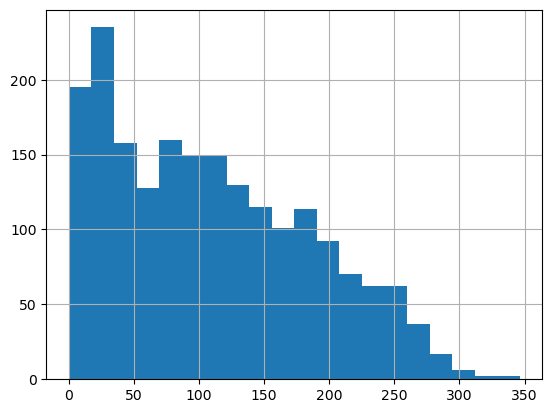

In [14]:
%matplotlib inline
df_MB.RFS_MONTHS.hist(bins=20)

In [15]:
df_MB[df_MB.RFS_MONTHS > 5 * 12].shape

(1340, 35)

## 全体の再発期間のばらつき

In [16]:
year = 5
df_tmp = df_MB[df_MB.RFS_STATUS == "0:Not Recurred"]
print((df_tmp.RFS_MONTHS > 12 * year).sum())
df_tmp = df_MB[df_MB.RFS_STATUS == "1:Recurred"]
print((df_tmp.RFS_MONTHS <= 12 * year).sum())
df_tmp = df_MB[df_MB.RFS_STATUS == "1:Recurred"]
print((df_tmp.RFS_MONTHS > 12 * year).sum())

1031
495
309


### 分布ヒストグラム

Text(0.5, 0, 'months')

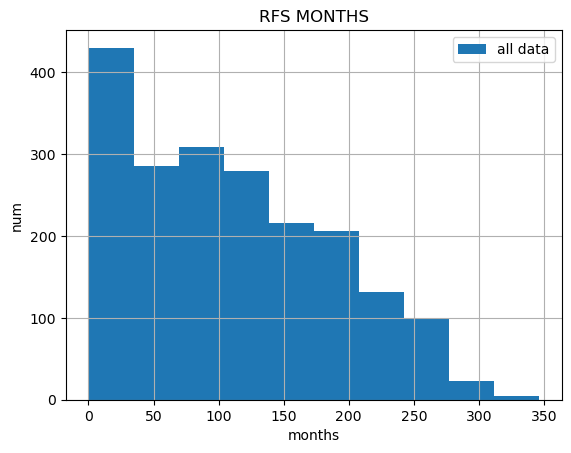

In [17]:
df_MB.RFS_MONTHS.hist(bins=int(math.log2(df_MB.shape[0])), label="all data")
plt.legend()
plt.title("RFS MONTHS")
plt.ylabel("num")
plt.xlabel("months")

0:Not Reccured -> 初診から最終フォローアップまでの期間なので注意

Text(0.5, 0, 'months')

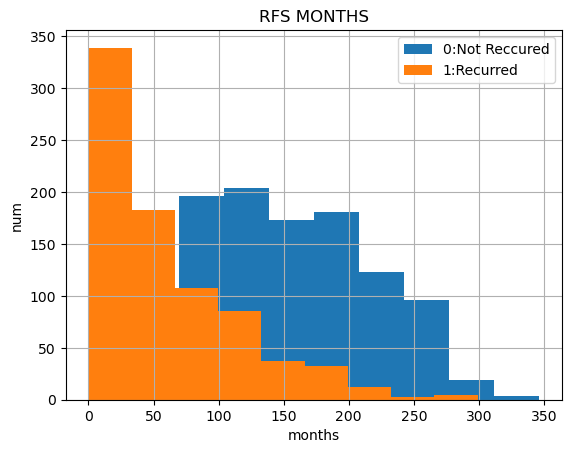

In [18]:
df_tmp = df_MB[df_MB.RFS_STATUS == "0:Not Recurred"]
df_tmp.RFS_MONTHS.hist(bins=int(math.log2(df_tmp.shape[0])), label="0:Not Reccured")
df_tmp = df_MB[df_MB.RFS_STATUS == "1:Recurred"]
df_tmp.RFS_MONTHS.hist(bins=int(math.log2(df_tmp.shape[0])), label="1:Recurred")

plt.legend()
plt.title("RFS MONTHS")
plt.ylabel("num")
plt.xlabel("months")

### KM lineの描画
全体の再発期間の可視化のためにカプランマイヤー曲線を描画

**打ち切り**
右側打ち切り：再発なし患者  
左側打ち切り：なし（今回のデータでは初診からすでに再発している患者がいるか不明なため）  

**注意点**
RFS_MONTHSは再発者であれば初診～再発の期間を示すが、非再発者であれば初診から最終フォローアップまでの期間を示している。  

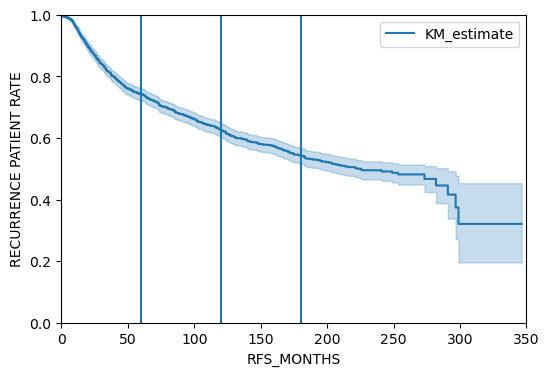

In [19]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()

df_tmp = df_MB[["RFS_MONTHS", "RFS_STATUS"]]
df_tmp = df_tmp.replace({"0:Not Recurred": False, "1:Recurred": True})
kmf = KaplanMeierFitter()
kmf.fit(durations=df_tmp.RFS_MONTHS, event_observed=df_tmp.RFS_STATUS)
kmf.plot()

ax.set_xlabel("RFS_MONTHS")
ax.set_ylabel("RECURRENCE PATIENT RATE")
ax.axvline(5 * 12)
ax.axvline(10 * 12)
ax.axvline(15 * 12)
plt.xlim(0, 350)
plt.ylim(0, 1.0)
plt.show()

In [20]:
def EDA_subgroup_relations(subgroup_name: str, year: int):
    # 統計情報
    print("欠損値数：", df_MB[subgroup_name].isna().sum())
    df_recurred = df_MB[df_MB.RFS_STATUS == "1:Recurred"]
    print("再発者/全患者")
    print(
        df_recurred[subgroup_name].value_counts() / df_MB[subgroup_name].value_counts()
    )
    print("{0}年以内再発者/全再発者".format(year))
    print(
        df_recurred[df_recurred.RFS_MONTHS <= 12 * year][subgroup_name].value_counts()
        / df_recurred[subgroup_name].value_counts()
    )
    print("{0}年以後再発者/全再発者".format(year))
    print(
        df_recurred[df_recurred.RFS_MONTHS > 12 * year][subgroup_name].value_counts()
        / df_recurred[subgroup_name].value_counts()
    )

    # カプランマイヤー曲線可視化
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot()

    for subgroup in df_MB[subgroup_name].unique():
        if type(subgroup) != str:
            continue
        df_subgroup = df_MB[df_MB[subgroup_name] == subgroup][
            ["RFS_MONTHS", "RFS_STATUS"]
        ]
        df_subgroup = df_subgroup.replace({"0:Not Recurred": False, "1:Recurred": True})
        kmf = KaplanMeierFitter()
        kmf.fit(
            durations=df_subgroup.RFS_MONTHS,
            event_observed=df_subgroup.RFS_STATUS,
            label=subgroup,
        )
        kmf.plot(ci_show=False)
    ax.set_xlabel("RFS_MONTHS")
    ax.set_ylabel("RECURRENCE PATIENT RATE")
    ax.axvline(5 * 12)
    ax.axvline(10 * 12)
    ax.axvline(15 * 12)
    plt.title(subgroup_name)
    plt.xlim(0, 350)
    plt.ylim(0, 1.0)
    plt.show()
    del df_recurred, df_subgroup

## サブグループの特徴がカテゴリ変数の場合

### CLAUDIN_SUBTYPE

注目したい要因

欠損値数： 5
再発者/全患者
Basal          0.444976
Her2           0.517857
LumA           0.330472
LumB           0.477895
NC             0.500000
Normal         0.439189
claudin-low    0.311927
Name: CLAUDIN_SUBTYPE, dtype: float64
5年以内再発者/全再発者
Basal          0.903226
Her2           0.732759
LumA           0.458874
LumB           0.607930
NC             0.666667
Normal         0.569231
claudin-low    0.632353
Name: CLAUDIN_SUBTYPE, dtype: float64
5年以後再発者/全再発者
Basal          0.096774
Her2           0.267241
LumA           0.541126
LumB           0.392070
NC             0.333333
Normal         0.430769
claudin-low    0.367647
Name: CLAUDIN_SUBTYPE, dtype: float64


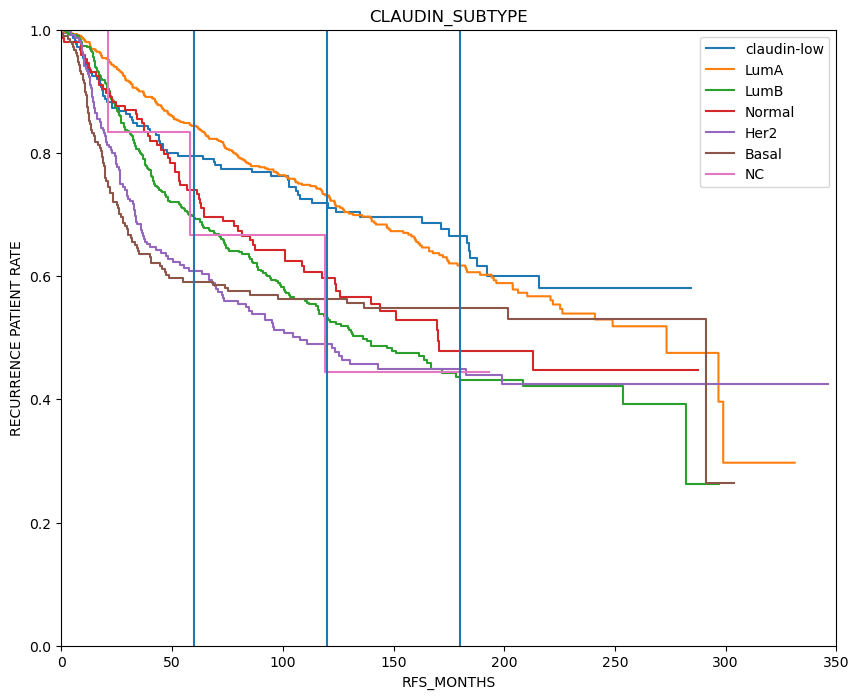

In [21]:
EDA_subgroup_relations("CLAUDIN_SUBTYPE", 5)

### その他の要因（注目度低）

欠損値数： 0
再発者/全患者
BRCA      0.272727
BREAST    0.235294
IDC       0.413255
ILC       0.410959
IMMC      0.217391
MBC       0.500000
MDLC      0.407583
PBS            NaN
Name: ONCOTREE_CODE, dtype: float64
5年以内再発者/全再発者
IDC       0.627358
MDLC      0.523256
ILC       0.683333
BRCA      0.333333
IMMC      0.600000
BREAST    0.500000
MBC       1.000000
Name: ONCOTREE_CODE, dtype: float64
5年以後再発者/全再発者
BRCA      0.666667
BREAST    0.500000
IDC       0.372642
ILC       0.316667
IMMC      0.400000
MBC            NaN
MDLC      0.476744
Name: ONCOTREE_CODE, dtype: float64


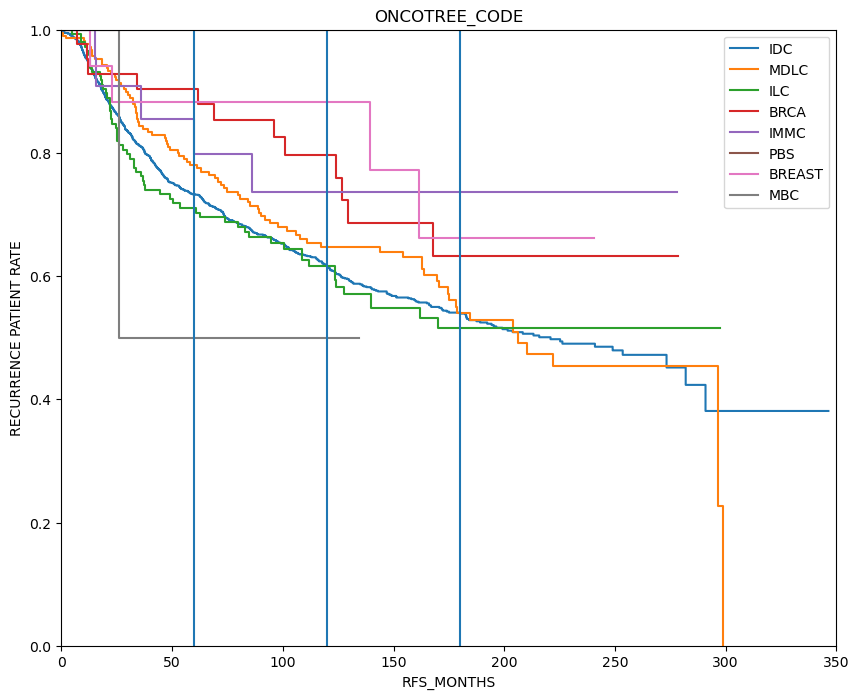

欠損値数： 0
再発者/全患者
Positive    0.394702
Negative    0.438819
Name: ER_STATUS, dtype: float64
5年以内再発者/全再発者
Positive    0.528523
Negative    0.865385
Name: ER_STATUS, dtype: float64
5年以後再発者/全再発者
Positive    0.471477
Negative    0.134615
Name: ER_STATUS, dtype: float64


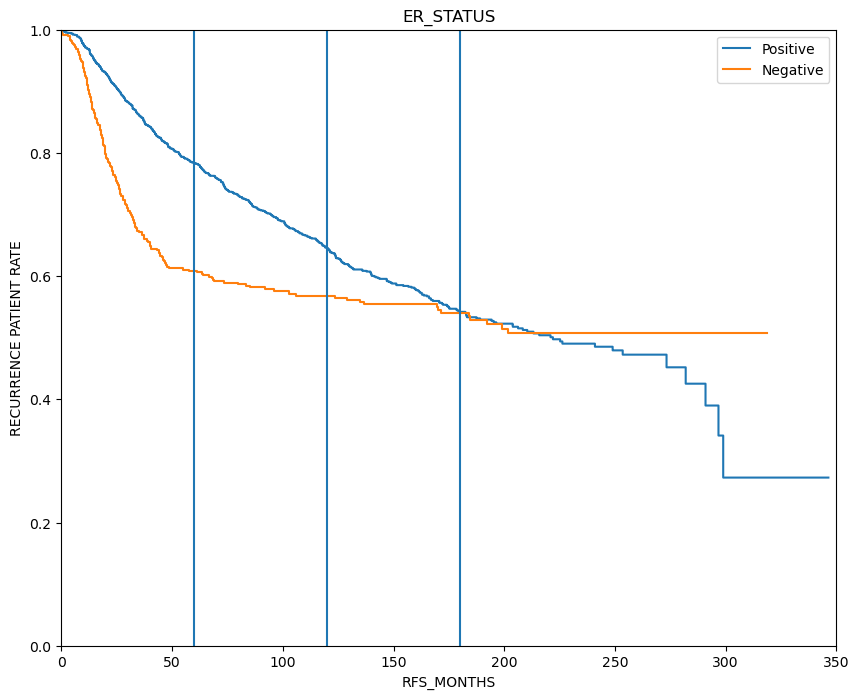

欠損値数： 43
再発者/全患者
Positve     0.395473
Negative    0.453303
Name: ER_IHC, dtype: float64
5年以内再発者/全再発者
Positve     0.542088
Negative    0.844221
Name: ER_IHC, dtype: float64
5年以後再発者/全再発者
Positve     0.457912
Negative    0.155779
Name: ER_IHC, dtype: float64


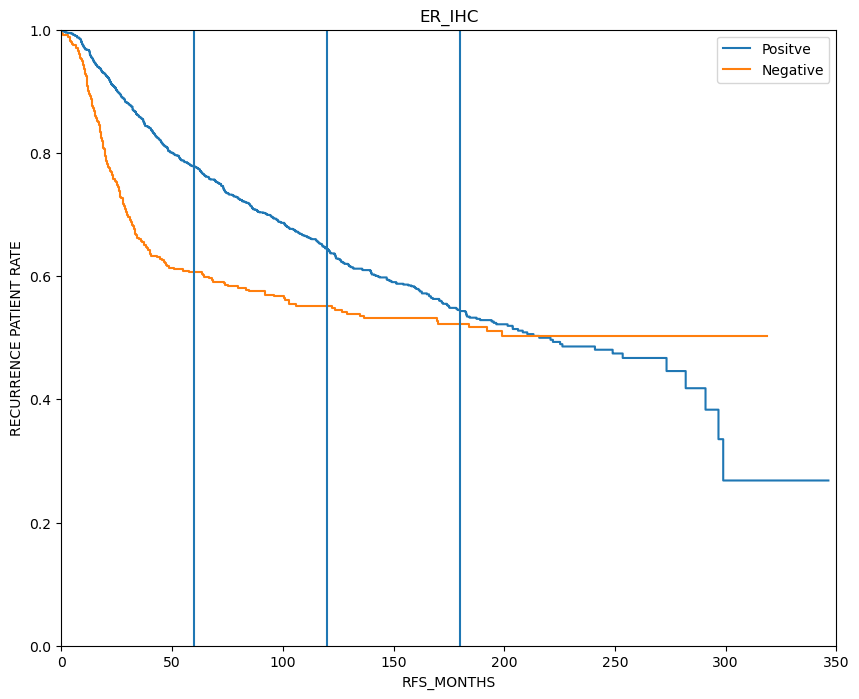

欠損値数： 5
再発者/全患者
Negative    0.389145
Positive    0.522267
Name: HER2_STATUS, dtype: float64
5年以内再発者/全再発者
Negative    0.586053
Positive    0.775194
Name: HER2_STATUS, dtype: float64
5年以後再発者/全再発者
Negative    0.413947
Positive    0.224806
Name: HER2_STATUS, dtype: float64


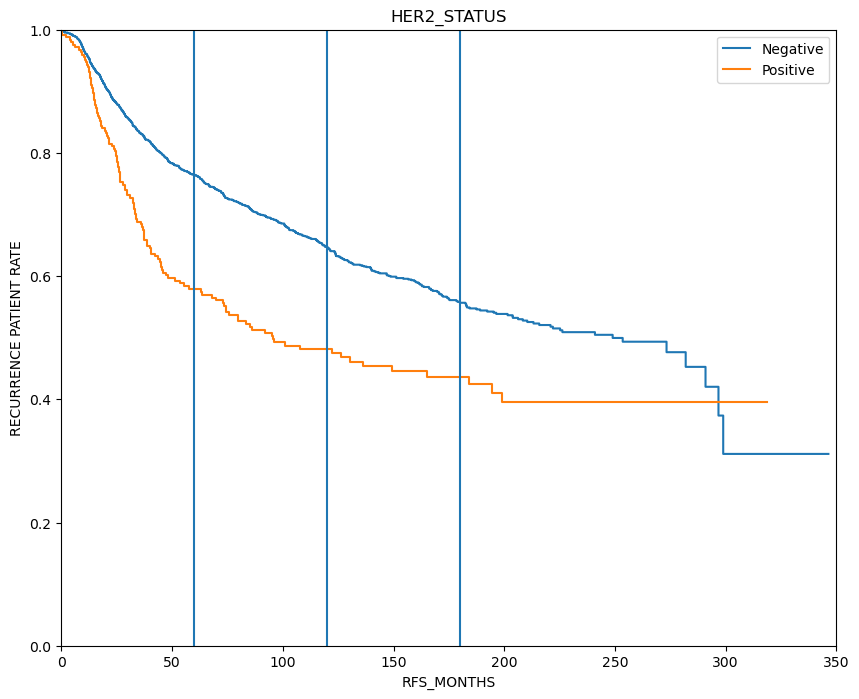

欠損値数： 5
再発者/全患者
NEUTRAL    0.381616
GAIN       0.474886
LOSS       0.440000
UNDEF      0.600000
Name: HER2_SNP6, dtype: float64
5年以内再発者/全再発者
NEUTRAL    0.578467
GAIN       0.725962
LOSS       0.568182
UNDEF      0.666667
Name: HER2_SNP6, dtype: float64
5年以後再発者/全再発者
NEUTRAL    0.421533
GAIN       0.274038
LOSS       0.431818
UNDEF      0.333333
Name: HER2_SNP6, dtype: float64


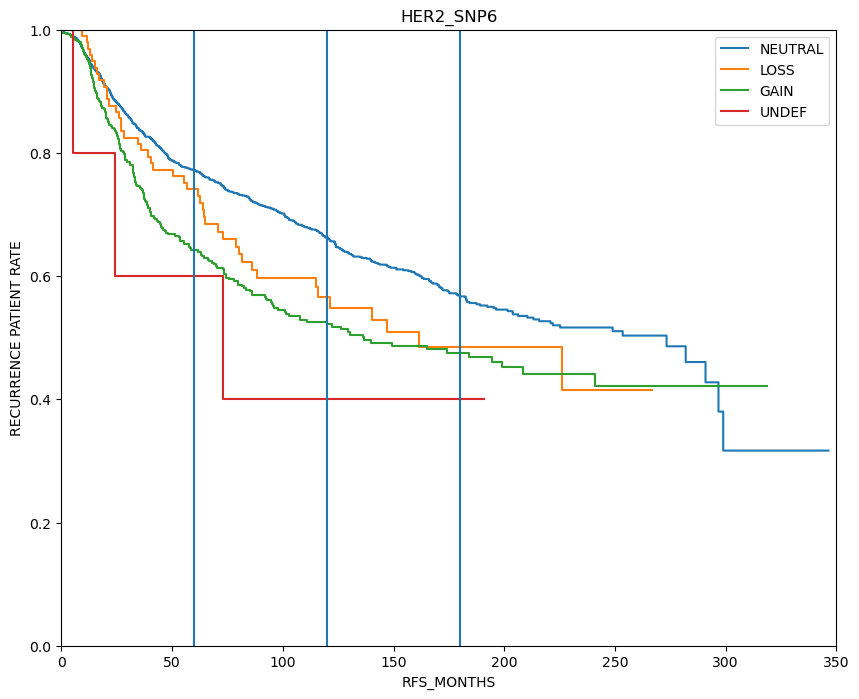

欠損値数： 5
再発者/全患者
Negative    0.431915
Positive    0.382098
Name: PR_STATUS, dtype: float64
5年以内再発者/全再発者
Negative    0.726601
Positive    0.503778
Name: PR_STATUS, dtype: float64
5年以後再発者/全再発者
Negative    0.273399
Positive    0.496222
Name: PR_STATUS, dtype: float64


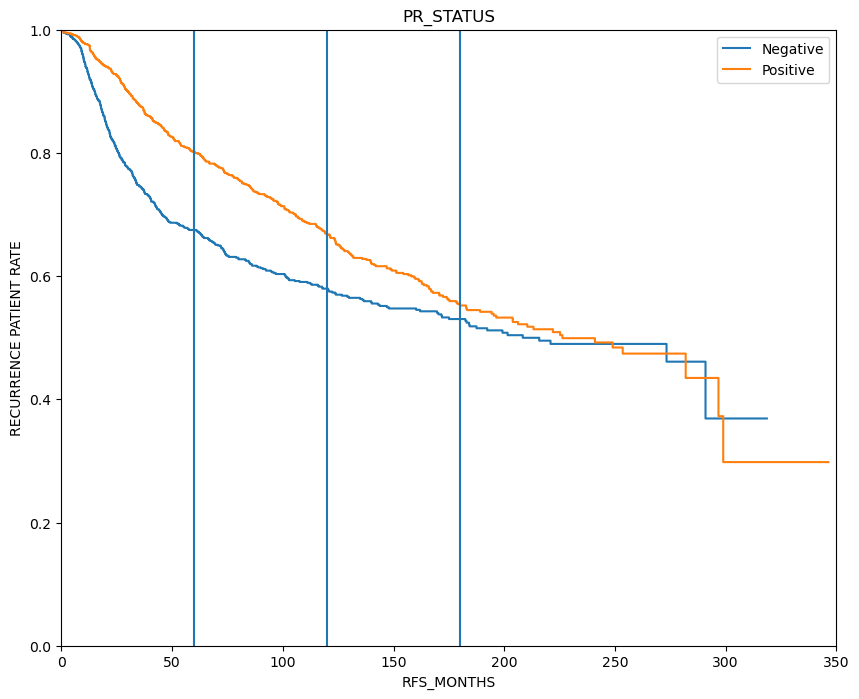

欠損値数： 221
再発者/全患者
ER+/HER2- High Prolif    0.452922
ER+/HER2- Low Prolif     0.325000
ER-/HER2-                0.378641
HER2+                    0.510101
Name: THREEGENE, dtype: float64
5年以内再発者/全再発者
ER+/HER2- High Prolif    0.612903
ER+/HER2- Low Prolif     0.423077
ER-/HER2-                0.803419
HER2+                    0.831683
Name: THREEGENE, dtype: float64
5年以後再発者/全再発者
ER+/HER2- High Prolif    0.387097
ER+/HER2- Low Prolif     0.576923
ER-/HER2-                0.196581
HER2+                    0.168317
Name: THREEGENE, dtype: float64


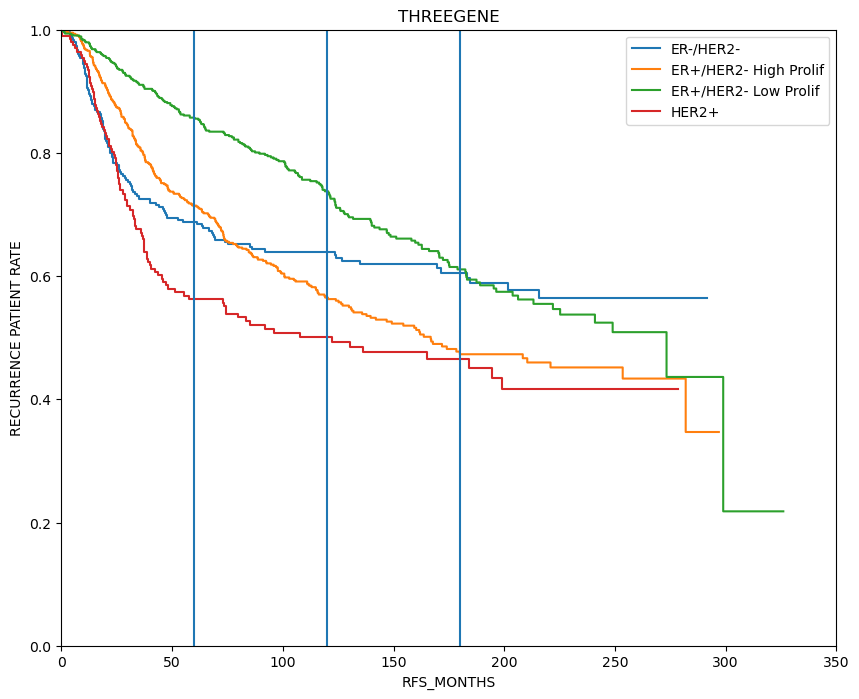

欠損値数： 46
再発者/全患者
Ductal/NST             0.417950
Lobular                0.410959
Medullary              0.360000
Metaplastic            0.500000
Mixed                  0.407583
Mucinous               0.217391
Other                  0.235294
Tubular/ cribriform    0.142857
Name: HISTOLOGICAL_SUBTYPE, dtype: float64
5年以内再発者/全再発者
Ductal/NST             0.631410
Lobular                0.683333
Medullary              0.555556
Metaplastic            1.000000
Mixed                  0.523256
Mucinous               0.600000
Other                  0.500000
Tubular/ cribriform         NaN
Name: HISTOLOGICAL_SUBTYPE, dtype: float64
5年以後再発者/全再発者
Ductal/NST             0.368590
Lobular                0.316667
Medullary              0.444444
Metaplastic                 NaN
Mixed                  0.476744
Mucinous               0.400000
Other                  0.500000
Tubular/ cribriform    1.000000
Name: HISTOLOGICAL_SUBTYPE, dtype: float64


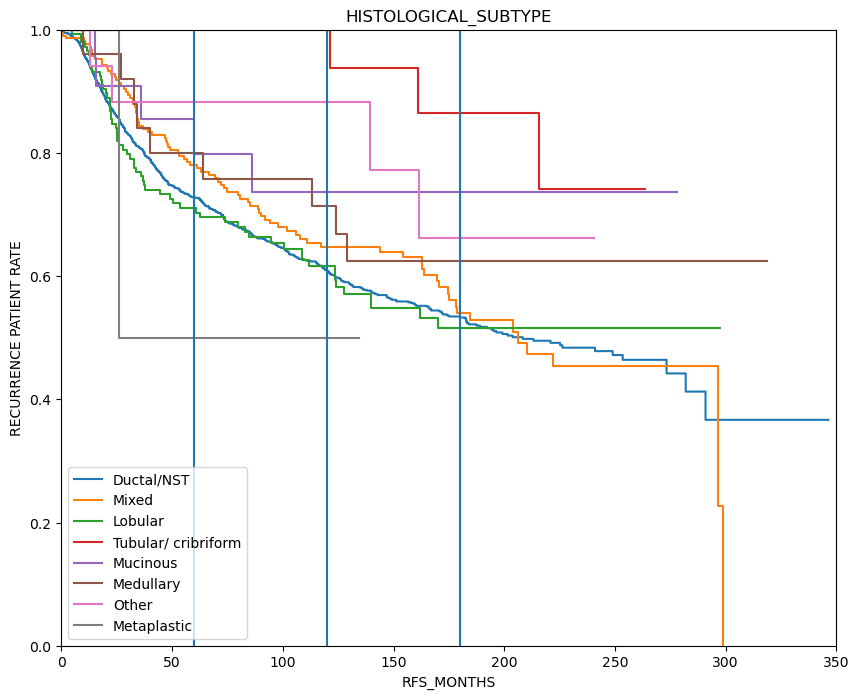

欠損値数： 5
再発者/全患者
YES    0.398849
NO     0.416776
Name: HORMONE_THERAPY, dtype: float64
5年以内再発者/全再発者
YES    0.562887
NO     0.698113
Name: HORMONE_THERAPY, dtype: float64
5年以後再発者/全再発者
YES    0.437113
NO     0.301887
Name: HORMONE_THERAPY, dtype: float64


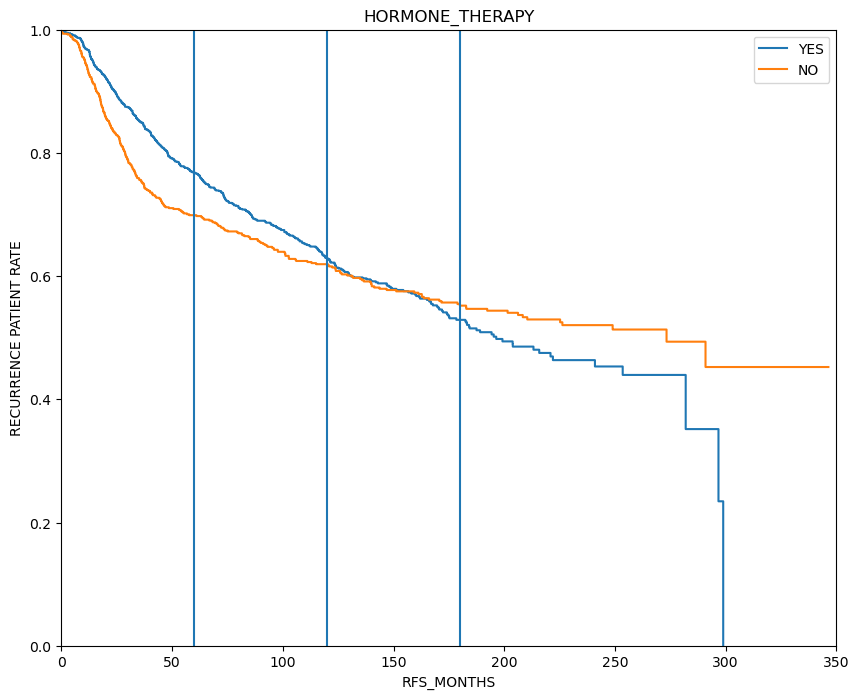

欠損値数： 5
再発者/全患者
YES    0.411263
NO     0.397770
Name: RADIO_THERAPY, dtype: float64
5年以内再発者/全再発者
YES    0.618257
NO     0.613707
Name: RADIO_THERAPY, dtype: float64
5年以後再発者/全再発者
YES    0.381743
NO     0.386293
Name: RADIO_THERAPY, dtype: float64


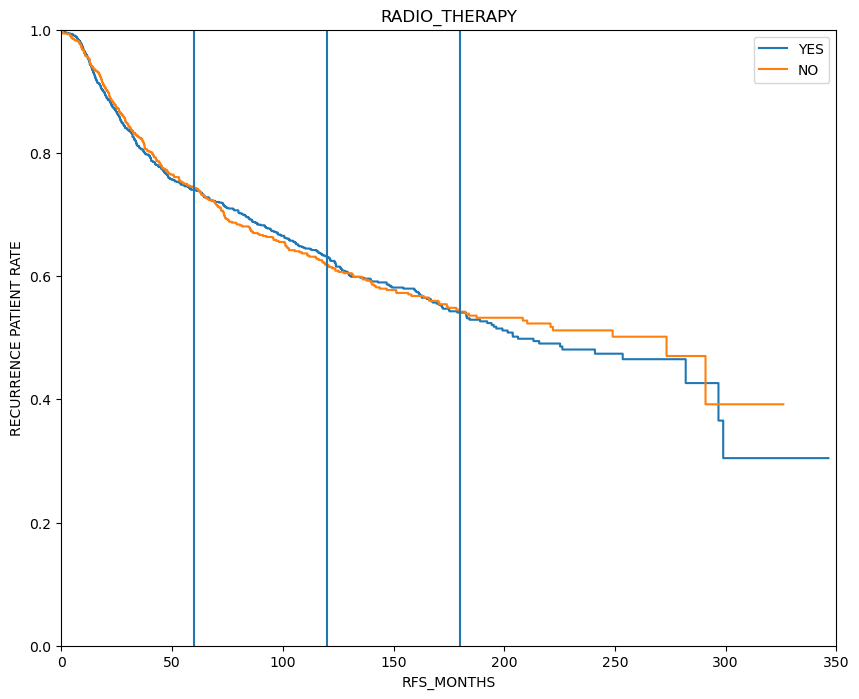

欠損値数： 30
再発者/全患者
MASTECTOMY           0.445299
BREAST CONSERVING    0.346939
Name: BREAST_SURGERY, dtype: float64
5年以内再発者/全再発者
MASTECTOMY           0.652591
BREAST CONSERVING    0.540441
Name: BREAST_SURGERY, dtype: float64
5年以後再発者/全再発者
MASTECTOMY           0.347409
BREAST CONSERVING    0.459559
Name: BREAST_SURGERY, dtype: float64


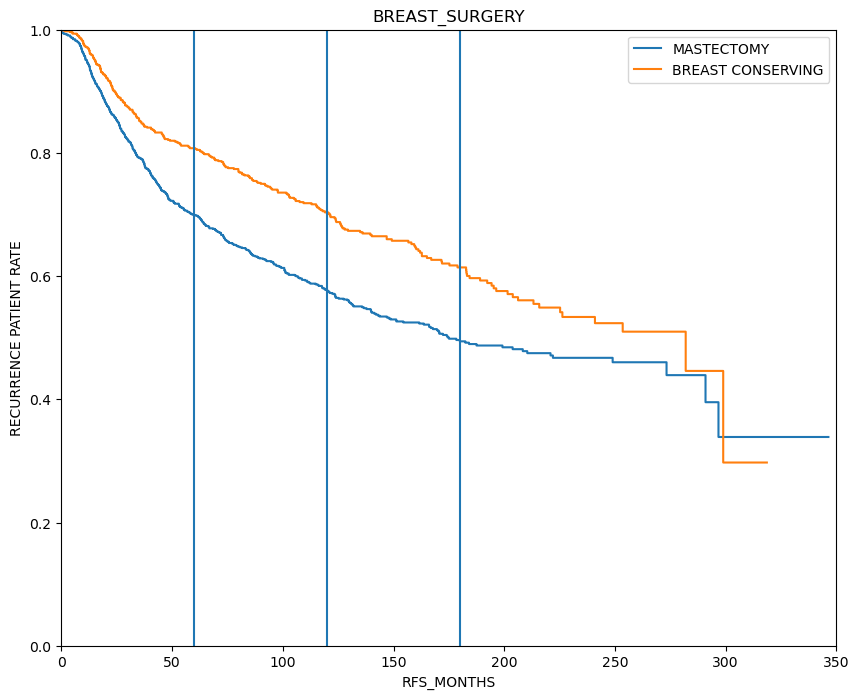

欠損値数： 5
再発者/全患者
NO     0.370772
YES    0.538835
Name: CHEMOTHERAPY, dtype: float64
5年以内再発者/全再発者
NO     0.555938
YES    0.774775
Name: CHEMOTHERAPY, dtype: float64
5年以後再発者/全再発者
NO     0.444062
YES    0.225225
Name: CHEMOTHERAPY, dtype: float64


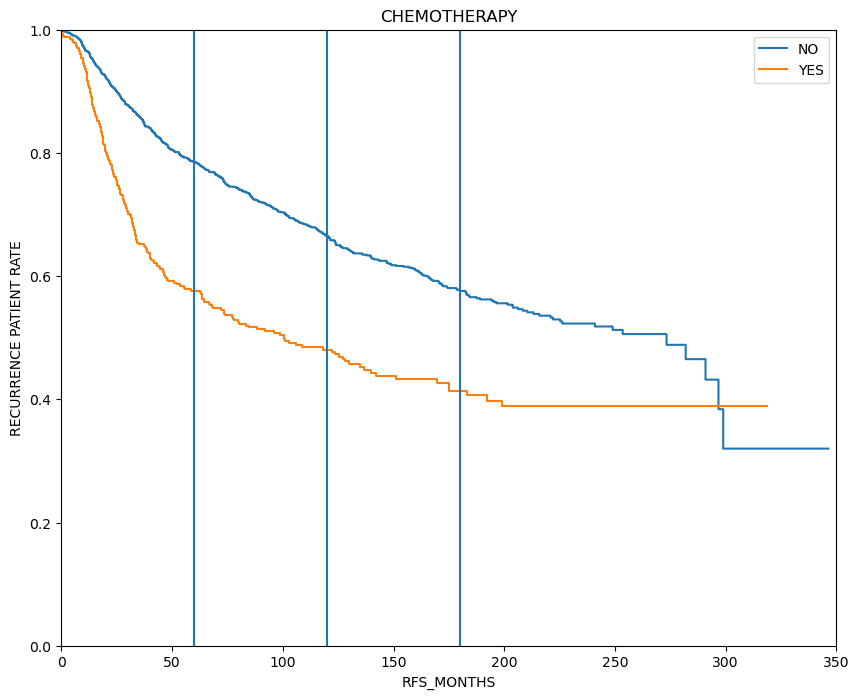

In [22]:
EDA_subgroup_relations("ONCOTREE_CODE", 5)
# ER, HER2
EDA_subgroup_relations("ER_STATUS", 5)
EDA_subgroup_relations("ER_IHC", 5)
EDA_subgroup_relations("HER2_STATUS", 5)
EDA_subgroup_relations("HER2_SNP6", 5)
EDA_subgroup_relations("PR_STATUS", 5)
# その他のサブタイプ
EDA_subgroup_relations("THREEGENE", 5)
EDA_subgroup_relations("HISTOLOGICAL_SUBTYPE", 5)
# 治療法
EDA_subgroup_relations("HORMONE_THERAPY", 5)
EDA_subgroup_relations("RADIO_THERAPY", 5)
EDA_subgroup_relations("BREAST_SURGERY", 5)
EDA_subgroup_relations("CHEMOTHERAPY", 5)

## サブグループの特徴が数値データの場合（カテゴリ化する必要がある）

### NPI
ノッティンガムの予後指数：https://en.wikipedia.org/wiki/Nottingham_Prognostic_Index  

欠損値数： 1
最小値： 1.0  最大値： 6.68


<AxesSubplot: >

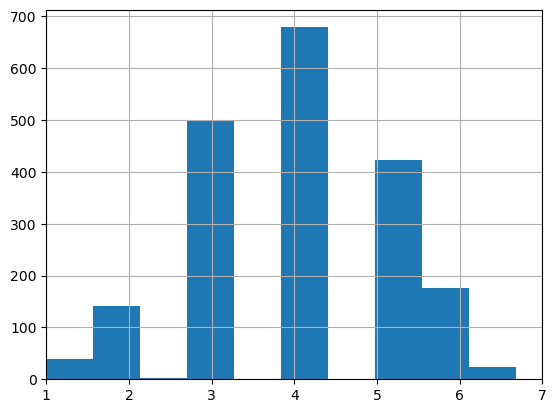

In [23]:
print("欠損値数：", df_MB.NPI.isna().sum())
print("最小値：", df_MB.NPI.min(), " 最大値：", df_MB.NPI.max())
plt.xlim(1, int(df_MB.NPI.max() + 1))
df_MB.NPI.hist(bins=int(math.log2(df_MB.shape[0])))

欠損値数： 1
再発者/全患者
3.4~5.4    0.407072
2.4~3.4    0.337349
5.4~inf    0.720000
2.0~2.4    0.239130
0.0~2.0    0.227273
Name: NPI_CAT, dtype: float64
5年以内再発者/全再発者
0.0~2.0    0.300000
2.0~2.4    0.515152
2.4~3.4    0.488095
3.4~5.4    0.632517
5.4~inf    0.756944
Name: NPI_CAT, dtype: float64
5年以後再発者/全再発者
3.4~5.4    0.367483
2.4~3.4    0.511905
5.4~inf    0.243056
2.0~2.4    0.484848
0.0~2.0    0.700000
Name: NPI_CAT, dtype: float64


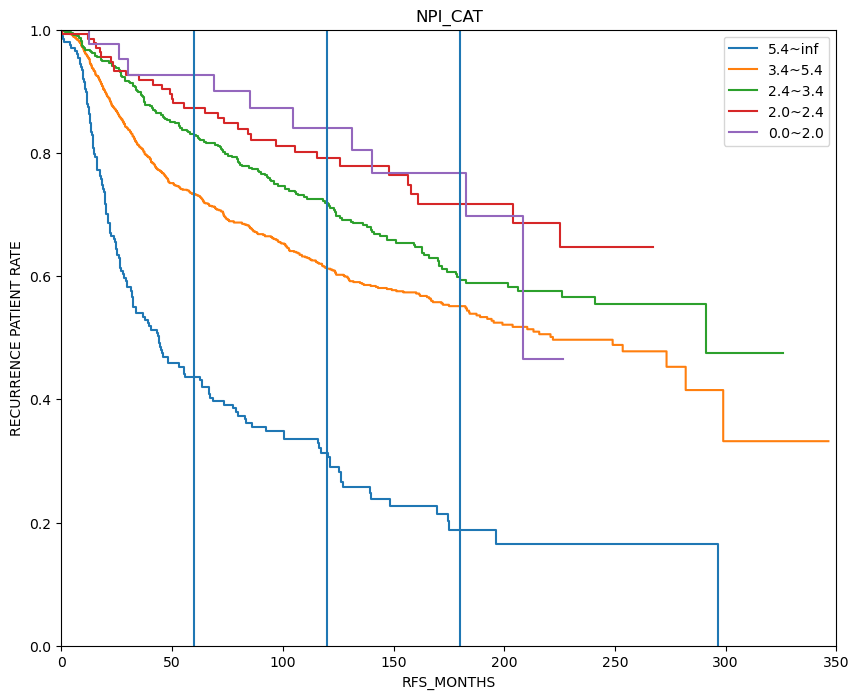

In [24]:
year = 5
df_MB["NPI_CAT"] = pd.cut(
    df_MB.NPI,
    [0, 2.0, 2.4, 3.4, 5.4, np.inf],
    labels=["0.0~2.0", "2.0~2.4", "2.4~3.4", "3.4~5.4", "5.4~inf"],
)

EDA_subgroup_relations("NPI_CAT", 5)

### 腫瘍サイズ

乳癌のステージの定義：https://oshiete-gan.jp/breast/diagnosis/stages/detail.html

腫瘍サイズ0mm/20mm/50mmで区切るのがよさそう？

欠損値数： 26
最小値： 1.0  最大値： 182.0


<AxesSubplot: >

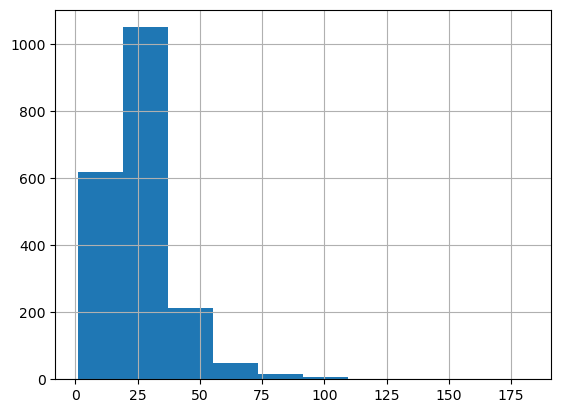

In [25]:
print("欠損値数：", df_MB.TUMOR_SIZE.isna().sum())
print("最小値：", df_MB.TUMOR_SIZE.min(), " 最大値：", df_MB.TUMOR_SIZE.max())
df_MB.TUMOR_SIZE.hist(bins=int(math.log2(df_MB.shape[0])))

欠損値数： 26
再発者/全患者
20~50     0.445219
0~20      0.342321
50~inf    0.554455
Name: TUMOR_CAT, dtype: float64
5年以内再発者/全再発者
20~50     0.644295
0~20      0.541096
50~inf    0.785714
Name: TUMOR_CAT, dtype: float64
5年以後再発者/全再発者
20~50     0.355705
0~20      0.458904
50~inf    0.214286
Name: TUMOR_CAT, dtype: float64


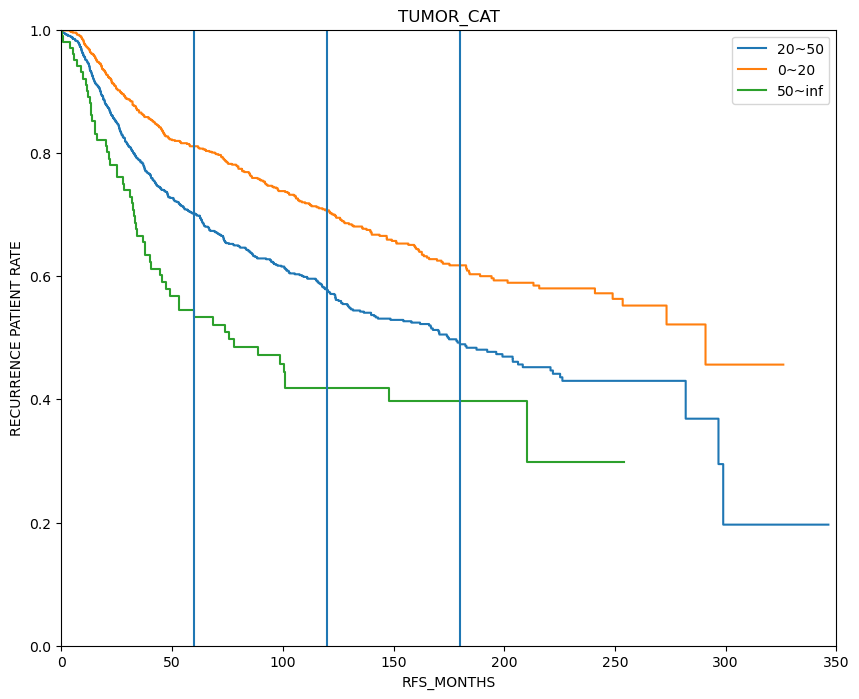

In [26]:
year = 5
df_MB["TUMOR_CAT"] = pd.cut(
    df_MB.TUMOR_SIZE, [0, 20, 50, np.inf], labels=["0~20", "20~50", "50~inf"]
)

EDA_subgroup_relations("TUMOR_CAT", 5)

### リンパ節陽性数

層別化ソース：https://medical.nikkeibp.co.jp/leaf/all/cancernavi/news/201403/535575.html

欠損値数： 76
最小値： 0.0  最大値： 45.0


<AxesSubplot: >

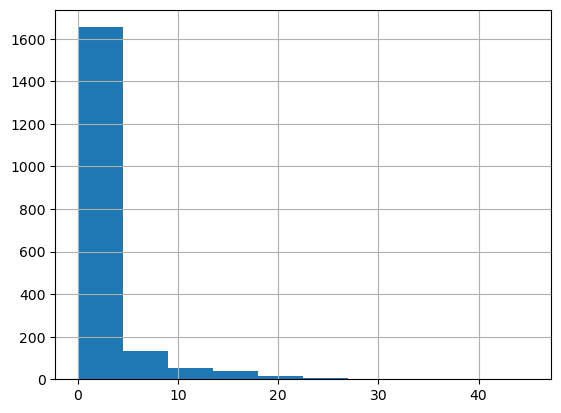

In [27]:
print("欠損値数：", df_MB.LYMPH_NODES_EXAMINED_POSITIVE.isna().sum())
print(
    "最小値：",
    df_MB.LYMPH_NODES_EXAMINED_POSITIVE.min(),
    " 最大値：",
    df_MB.LYMPH_NODES_EXAMINED_POSITIVE.max(),
)
df_MB.LYMPH_NODES_EXAMINED_POSITIVE.hist(bins=int(math.log2(df_MB.shape[0])))

In [28]:
print(
    "1/4分位点：",
    df_MB["LYMPH_NODES_EXAMINED_POSITIVE"].quantile(0.25),
    " 1/2分位点：",
    df_MB["LYMPH_NODES_EXAMINED_POSITIVE"].quantile(0.5),
    " 3/4分位点：",
    df_MB["LYMPH_NODES_EXAMINED_POSITIVE"].quantile(0.75),
)

1/4分位点： 0.0  1/2分位点： 0.0  3/4分位点： 2.0


欠損値数： 76
再発者/全患者
0        0.315895
1~3      0.422442
4~inf    0.655844
Name: LYMPH_CAT, dtype: float64
5年以内再発者/全再発者
0        0.566879
1~3      0.593750
4~inf    0.717822
Name: LYMPH_CAT, dtype: float64
5年以後再発者/全再発者
0        0.433121
1~3      0.406250
4~inf    0.282178
Name: LYMPH_CAT, dtype: float64


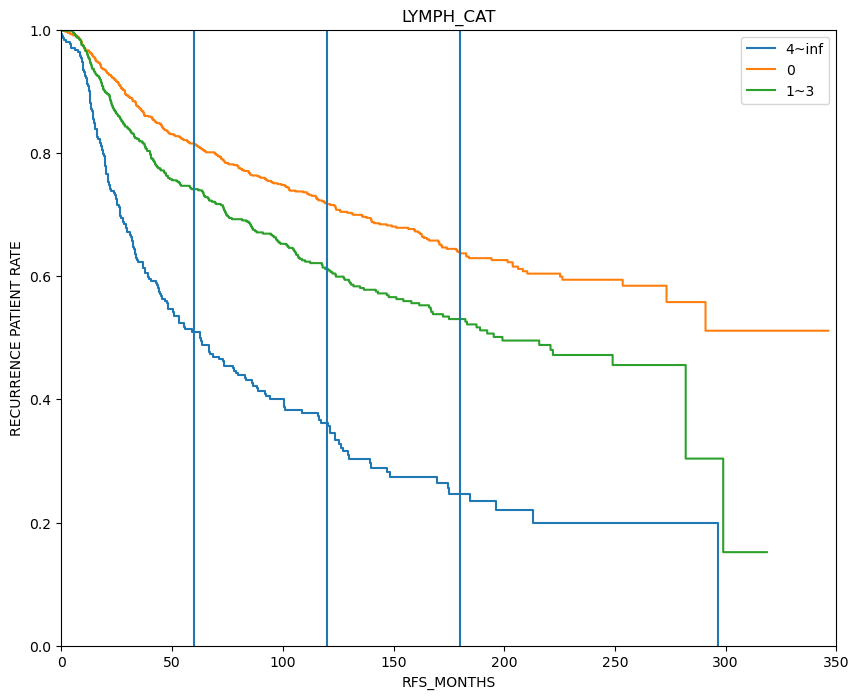

In [29]:
year = 5
df_MB["LYMPH_CAT"] = pd.cut(
    df_MB.LYMPH_NODES_EXAMINED_POSITIVE,
    [-np.inf, 0, 3, np.inf],
    labels=["0", "1~3", "4~inf"],
)

EDA_subgroup_relations("LYMPH_CAT", 5)

### その他の要因（注目度低）

欠損値数： 88
最小値： 1.0  最大値： 3.0


<AxesSubplot: >

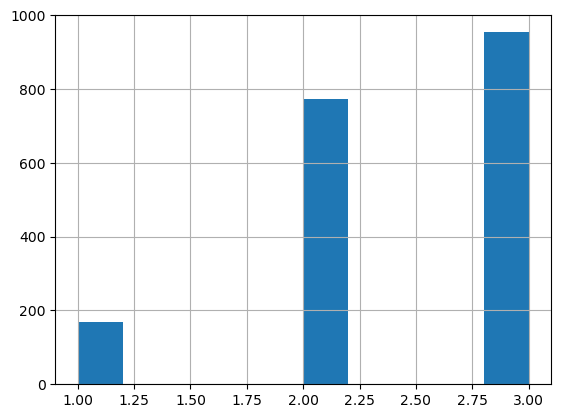

In [30]:
print("欠損値数：", df_MB.GRADE.isna().sum())
print(
    "最小値：",
    df_MB.GRADE.min(),
    " 最大値：",
    df_MB.GRADE.max(),
)
df_MB.GRADE.hist(bins=int(math.log2(df_MB.shape[0])))

欠損値数： 88
再発者/全患者
3    0.460168
2    0.379043
1    0.242604
Name: GRADE_CAT, dtype: float64
5年以内再発者/全再発者
3    0.710706
2    0.501706
1    0.512195
Name: GRADE_CAT, dtype: float64
5年以後再発者/全再発者
1    0.487805
2    0.498294
3    0.289294
Name: GRADE_CAT, dtype: float64


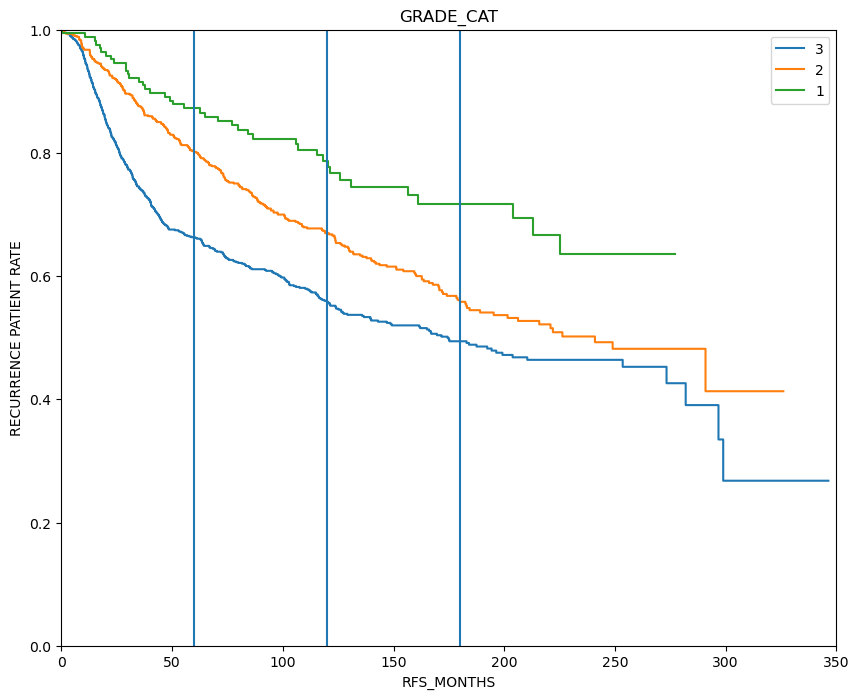

欠損値数： 0
再発者/全患者
c2    0.416099
c1    0.350877
c3    0.368794
Name: TMB_CAT, dtype: float64
5年以内再発者/全再発者
c2    0.613095
c1    0.575000
c3    0.711538
Name: TMB_CAT, dtype: float64
5年以後再発者/全再発者
c2    0.386905
c1    0.425000
c3    0.288462
Name: TMB_CAT, dtype: float64


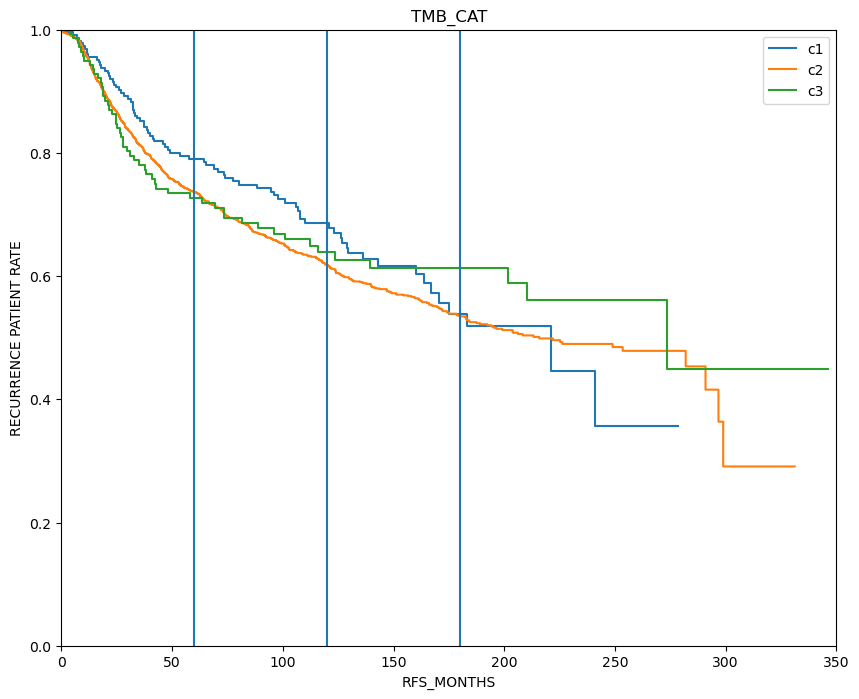

In [31]:
df_MB["GRADE_CAT"] = pd.cut(
    df_MB.GRADE,
    [0, 1, 2, 3],
    labels=[
        "1",
        "2",
        "3",
    ],
)

EDA_subgroup_relations("GRADE_CAT", 5)

df_MB["TMB_CAT"] = pd.qcut(
    df_MB.TMB_NONSYNONYMOUS, [0, 0.1, 0.9, 1], labels=["c1", "c2", "c3"]
)

EDA_subgroup_relations("TMB_CAT", 5)

# 遺伝子発現量データのEDA

## 各マイクロアレイ手法毎の確認

mrna_agilent_microarrayとmrna_agilent_microarray_zscores_ref_all_samplesの遺伝子は完全に一致しているが、mrna_agilent_microarray_zscores_ref_diploid_samplesはそれら2つとは違う（特徴量数が不足している）ことを確認済み

# 再発者のみのデータのEDA

2-preprocess_RFSノートブックから、前処理をして再発者に限定したdf: df_recurrencedを取り出す

In [32]:
# 臨床データ（層別化対象）と遺伝子データが結合されており、再発者に限定されている

df_recurrenced = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_recurrenced.pkl"
)

## 再発までの期間と遺伝子発現量の相関の確認

In [33]:
drop_columns = [
    "RFS_OVER_60MONTHS",
    "CLAUDIN_SUBTYPE",
    "NPI_CAT",
    "TUMOR_CAT",
    "LYMPH_CAT",
]
# サブクラス情報を削除
df_recurrenced_gene_expressions = df_recurrenced.drop(drop_columns, axis=1)

# 前処理後の再発者に限定した患者の、各遺伝子と再発までの期間の相関係数
# ※非再発者は再発期間がないので見ていない
corr=pd.merge(
    df_recurrenced_gene_expressions, df_MB.RFS_MONTHS, left_index=True, right_index=True
).corr()

<AxesSubplot: >

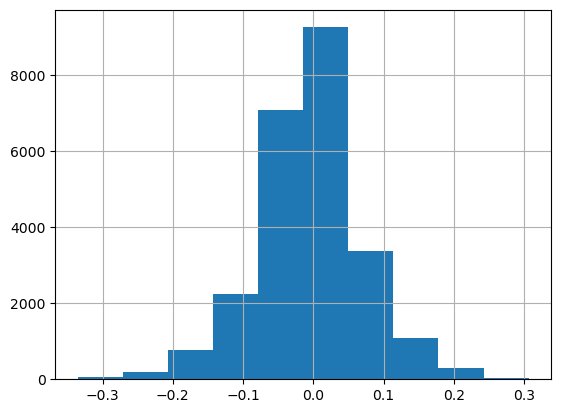

In [34]:
corr["RFS_MONTHS"].drop('RFS_MONTHS').sort_values(ascending=False).hist()

生の遺伝子発現量情報のみでは相関は見られない（目安：0.5以上ぐらいが相関があると考えられている）

# クラスタリング

遺伝子発現量数が多いが、削除してしまうと候補の対象外となってしまう→クラスターで特徴量数を削減した上で、代表値と再発期間の関連を見る

参考
- https://qiita.com/Hatomugi/items/d6c8bb1a049d3a84feaa
- https://qiita.com/g-k/items/120f1cf85ff2ceae4aba


## PCA
 
特徴量から平均を引く（センタリング）ことは必須  
しかし、標準偏差で割る（標準化する）ことについては議論があるとのこと
https://qiita.com/koshian2/items/2e69cb4981ae8fbd3bda

pcaによって説明分散比の95%を保持するクラスターの数:  527


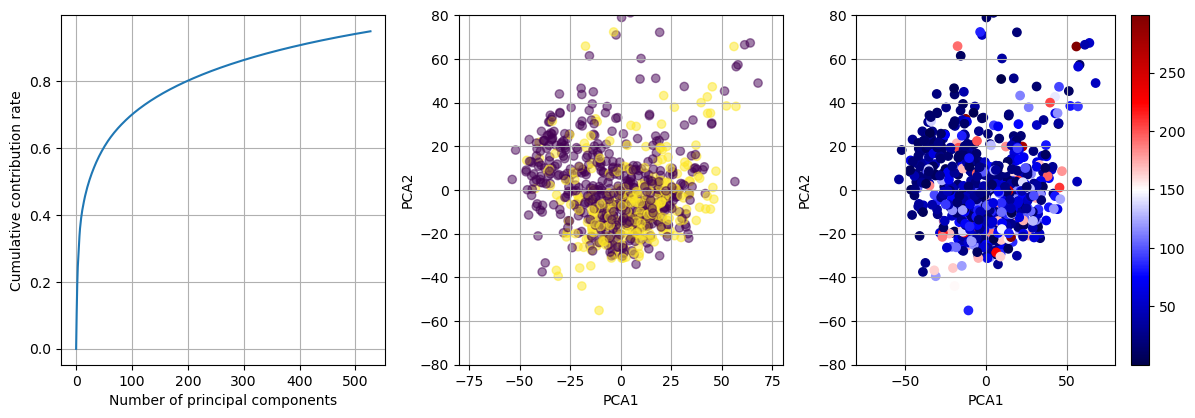

In [84]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy import stats

plt.figure(figsize=(12,12))

# 特徴量のセンタリング 
df_gene_expressions = df_mrna_agilent_microarray.copy()
df_center=df_recurrenced[df_gene_expressions.columns]-df_recurrenced[df_gene_expressions.columns].mean(axis=0)

# pca
pca = PCA(n_components=0.95, random_state=config.SEED)
pca.fit(df_center)
reduced_data = pca.transform(df_center)

# pcaで削減された後に残る情報量の推移の可視化
plt.subplot(331)
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative contribution rate")
plt.grid()
plt.plot([0] + list(np.cumsum(pca.explained_variance_ratio_)), "-")
print('pcaによって説明分散比の95%を保持するクラスターの数: ', pca.n_components_)


# pcaの前段階で標準化していないので、正直可視化しないほうが良い（ミスリードに繋がる）
# 2次元まで落とし込んだときの散布図（目的変数で色分け）
plt.subplot(332)
plt.scatter(
    reduced_data[:, 0],
    reduced_data[:, 1],
    alpha=0.5,
    c=list(df_recurrenced["RFS_OVER_60MONTHS"]),
)
plt.grid()
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.xlim(-80, 80)
plt.ylim(-80, 80)


import matplotlib.cm as cm
# 再発期間の数値情報
df_recurrenced2=pd.merge(df_MB['RFS_MONTHS'],df_recurrenced, right_index=True, left_index=True)

plt.subplot(333)
sc=plt.scatter(
    reduced_data[:, 0],
    reduced_data[:, 1],
    c=df_recurrenced2['RFS_MONTHS'],
    cmap=cm.seismic
)
plt.grid()
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.xlim(-80, 80)
plt.ylim(-80, 80)
plt.tight_layout()
plt.colorbar(sc)
plt.show()


,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24,...,pca502,pca503,pca504,pca505,pca506,pca507,pca508,pca509,pca510,pca511,pca512,pca513,pca514,pca515,pca516,pca517,pca518,pca519,pca520,pca521,pca522,pca523,pca524,pca525,pca526
MB-0005,-19.210907,-43.956184,10.747667,-2.680647,-37.664375,4.904092,-5.082113,-10.083609,1.269103,2.520596,4.738290,-6.599370,7.218610,5.943595,-0.666052,4.030349,2.212975,4.122140,1.904319,-6.056090,7.729317,4.735050,-5.670733,-7.996016,-7.464295,...,0.613682,-0.709940,-0.446375,0.852829,1.407886,0.583752,-1.354942,-1.157322,-0.481941,-1.562481,0.553587,2.206859,-1.410765,-0.998285,-0.569234,0.445617,0.566157,0.250485,-0.755796,1.248174,-0.016849,0.205039,-0.192479,0.665843,-0.241440
MB-0008,-2.769381,-14.350376,18.703963,-11.718727,8.525541,-0.513748,-2.052697,4.276718,-1.687435,-18.047319,-1.919406,-0.809611,-9.222852,9.852611,-4.936400,1.233135,6.631662,-7.805363,1.278120,-3.923841,13.270501,-2.751763,-1.859046,-6.230869,-5.001063,...,-0.611387,-0.913835,-1.524456,-3.495618,-0.800801,0.070463,0.957175,-0.152799,-0.380878,-0.088159,-1.673548,1.166589,0.087247,1.021571,-1.899605,-0.421107,0.235046,0.459020,0.975859,0.817744,0.311899,1.388907,0.212247,-0.140057,-1.129975
MB-0010,0.134570,-20.285394,9.727360,-4.619928,-14.954464,-10.760304,-6.364915,-5.916512,-5.142731,-1.884702,11.206425,-0.971912,4.923978,4.403236,-12.558840,-6.126854,9.384824,-6.416498,-1.679763,-7.190586,-4.434213,4.364023,-2.858392,-1.357562,0.282863,...,0.681981,0.721486,2.378202,0.250232,1.047617,1.190336,1.696129,1.929903,-0.605960,-1.809910,0.414186,-0.764143,-1.284155,0.546179,-0.679498,0.498310,-1.720036,-0.855444,-1.337613,-1.287157,-1.151581,-0.758778,-0.396858,-0.070463,-1.910578
MB-0035,18.789169,-0.944608,21.458576,3.611718,-18.115359,-5.210365,43.417171,2.436127,0.156516,12.835641,7.482983,17.327137,14.164761,8.394956,-5.838734,8.977597,15.051514,-0.398807,-2.881170,0.233322,12.613208,-0.937500,-6.486145,17.384527,-2.431675,...,-0.343538,-1.215371,0.412814,-1.340477,0.005097,-0.192392,-0.378274,0.902814,0.841192,-0.196388,0.932367,0.276453,-0.400540,-0.031391,0.146377,-1.014779,-0.681631,-1.117083,-0.608531,0.658878,-0.029068,-0.578591,0.961135,1.071616,-0.053516
MB-0036,19.132868,-14.983715,-1.441560,12.875501,15.597878,4.539355,-1.478919,-1.890862,28.003622,3.394133,5.082895,-5.872435,-11.512394,-11.566101,-1.492688,-2.324786,-10.240069,8.921599,6.493010,-8.567358,-4.929840,-1.731343,-10.883635,1.418383,-4.217881,...,2.232374,0.054772,-0.817562,-0.648250,2.405906,-2.094422,0.110520,-1.222971,-0.642230,-0.516418,0.992865,-1.362004,1.628603,-2.013374,0.039538,2.833759,-1.203500,0.249917,0.102466,-0.676594,-1.158150,1.172235,0.678037,0.331999,-2.324463


<AxesSubplot: >

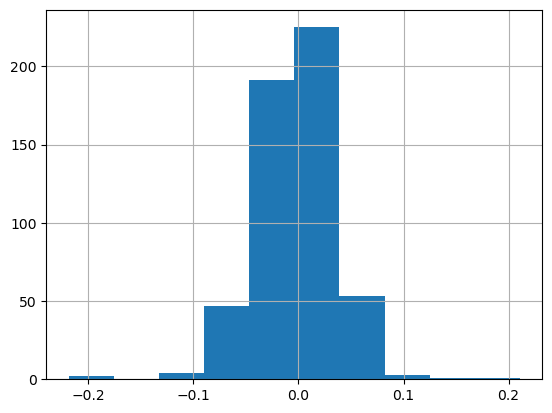

In [86]:
# PCA変換後の各サンプルへの値（PCAは何を表しているのだろう？平均値や中央値のような単純なものではなさそう）
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
df_pca=pd.DataFrame(reduced_data, index=df_recurrenced.index, columns=pca.get_feature_names_out())
display(df_pca.head())


# 再発期間との相関係数
corr_pca=pd.merge(
    df_pca, df_MB.RFS_MONTHS, left_index=True, right_index=True
).corr()
corr_pca["RFS_MONTHS"].drop('RFS_MONTHS').sort_values(ascending=False).hist()

- pca0ではESR1が最も表されており、DR033780は最も表されていない
- 再発期間との相関係数は低い

### pcaに変換する過程での、遺伝子発現量の寄与度合い（重要さ？）

In [87]:
# 遺伝子→pcaへ変換するための行列の一部（pca0）
# 因子負荷量の絶対値が大きい特徴量ほど、pca後の特徴量をよく表している。
# pcaへの寄与度合？の絶対値順に表示
pd.DataFrame(pca.components_, index=pca.get_feature_names_out(), columns=df_gene_expressions.columns).T['pca0'].apply(lambda x: abs(x)).sort_values(ascending=False)

Hugo_Symbol
ESR1        7.376479e-02
ANKRD30A    6.209822e-02
AGR3        6.158104e-02
TFF3        6.120205e-02
U79293      6.078438e-02
                ...     
W36271      2.048198e-07
AI673691    1.791555e-07
CCDC54      1.558866e-07
PRSS53      2.485470e-08
DR033780    8.897519e-09
Name: pca0, Length: 24368, dtype: float64

PCAによるクラスタリングでは、相関係数上、有力と考えられそうなpca特徴量は見られない  
（元のデータで相関係数が低かった都合上、クラスタリングしても難しいのかもしれない）

## LDA: LinearDiscriminantAnalysis（線形判別分析）
(LatentDirichletAllocationではないので注意)

https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 特徴量のセンタリング 
df_gene_expressions = df_mrna_agilent_microarray.copy()
df_center=df_recurrenced[df_gene_expressions.columns]-df_recurrenced[df_gene_expressions.columns].mean(axis=0)


clf=LinearDiscriminantAnalysis()
clf.fit(df_center)
clf.transform(df_center)


## KMeans

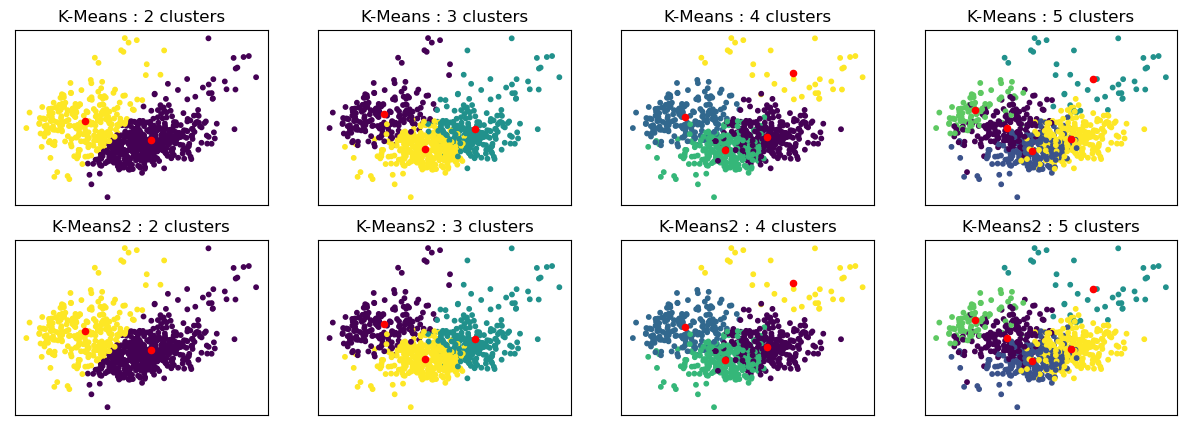

In [39]:
from sklearn.cluster import  KMeans

X=df_recurrenced[df_gene_expressions.columns].copy()

# Number of cluster centers for KMeans and BisectingKMeans
n_clusters_list = [2, 3, 4, 5]

# Algorithms to compare
clustering_algorithms = {
    "K-Means": KMeans,
    "K-Means2": KMeans,
}

# Make subplots for each variant
fig, axs = plt.subplots(
    len(clustering_algorithms), len(n_clusters_list), figsize=(15, 5)
)

axs = axs.T

for i, (algorithm_name, Algorithm) in enumerate(clustering_algorithms.items()):
    for j, n_clusters in enumerate(n_clusters_list):
        algo = Algorithm(n_clusters=n_clusters, random_state=config.SEED)
        algo.fit(reduced_data)
        centers = algo.cluster_centers_
        axs[j, i].scatter(reduced_data[:, 0], reduced_data[:, 1], s=10, c=algo.labels_)
        axs[j, i].scatter(centers[:, 0], centers[:, 1], c="r", s=20)
        axs[j, i].set_title(f"{algorithm_name} : {n_clusters} clusters")


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])
    

plt.show()